In [17]:
from glob import glob
import pandas as pd
import imageio as iio
import matplotlib.pyplot as plt
import numpy as np
import itertools
from skan.csr import skeleton_to_csgraph, make_degree_image, pixel_graph
from skan import Skeleton, summarize, draw
from skan.pre import threshold
import skimage.morphology as sk
from skimage.segmentation import find_boundaries, watershed
from skimage.filters import rank, sobel, threshold_otsu
from skimage.restoration import rolling_ball
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
import networkx as nx
from scipy import ndimage as ndi
import os

from source import segmentation_hand
from utils import fileio
from utils import handtrace
from utils import matrices
from utils import geometry
from utils import mechanics
from utils import visualise

In [4]:
files=glob("C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Stretched/Tracked/20240503_1_IP_GFPCAAX-CheHis_uf_8p6_SP/Frames/*.tif")
image0 = iio.v2.imread(files[0])
im_g=image0[:,:,1]

<Figure size 1000x1000 with 0 Axes>

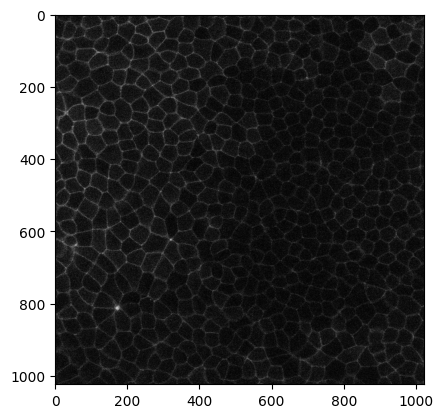

In [20]:
plt.figure(figsize=(10,10))
fig, ax = plt.subplots()
ax.imshow(image0[:,:,1], cmap='gray');

plt.show()

In [6]:
from skimage import feature

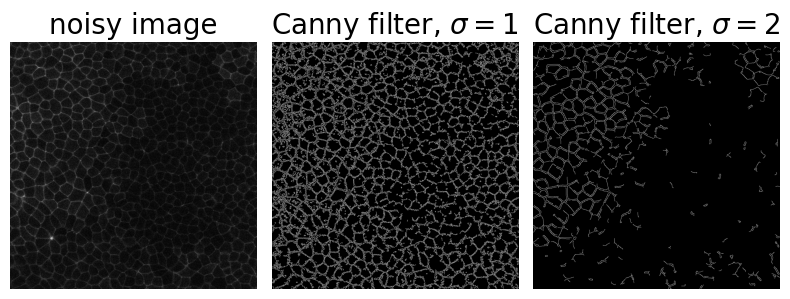

In [7]:
# Compute the Canny filter for two values of sigma
edges1 = feature.canny(im_g)
edges2 = feature.canny(im_g, sigma=2)

# display results
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 3))

ax[0].imshow(im_g, cmap='gray')
ax[0].set_title('noisy image', fontsize=20)

ax[1].imshow(edges1, cmap='gray')
ax[1].set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax[2].imshow(edges2, cmap='gray')
ax[2].set_title(r'Canny filter, $\sigma=2$', fontsize=20)

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

<Figure size 1500x1500 with 0 Axes>

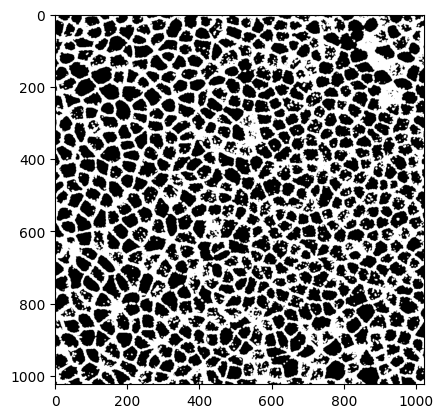

In [8]:
# Compute the Canny filter for two values of sigma
edges1 = rank.mean(im_g, footprint=sk.disk(2)) 
edges1=threshold(edges1, sigma=1,radius=int(edges1.shape[0]/12))
edges1=sk.binary_dilation(edges1)
plt.figure(figsize=(15,15))
fig, ax = plt.subplots()
ax.imshow(edges1, cmap='gray');

plt.show()


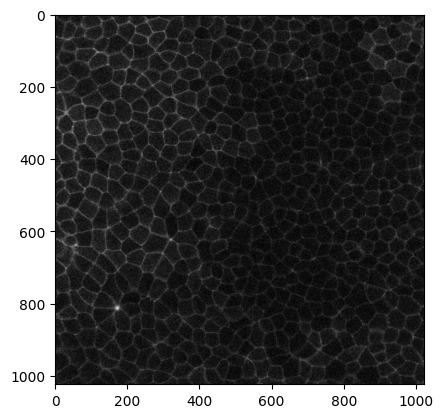

In [9]:
test=sk.closing(im_g)

plt.imshow(test, cmap='gray');

(-0.5, 1023.5, 1023.5, -0.5)

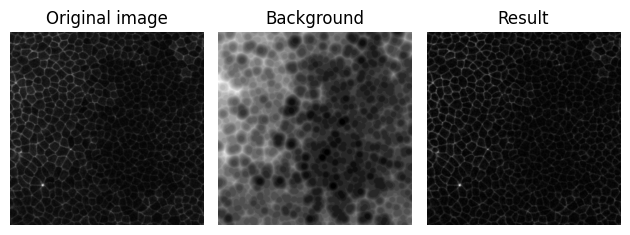

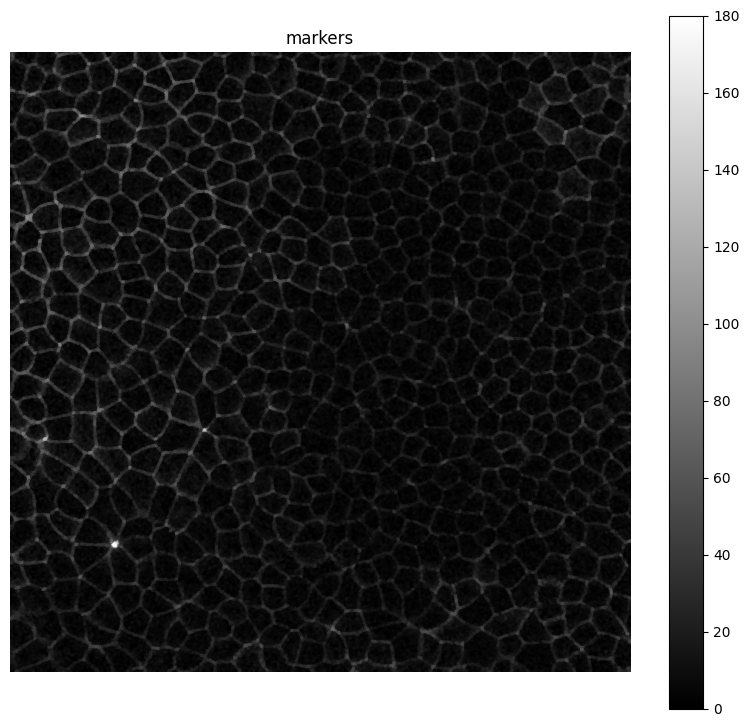

In [10]:
def plot_result(image, background):
    fig, ax = plt.subplots(nrows=1, ncols=3)

    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('Original image')
    ax[0].axis('off')

    ax[1].imshow(background, cmap='gray')
    ax[1].set_title('Background')
    ax[1].axis('off')

    ax[2].imshow(image - background, cmap='gray')
    ax[2].set_title('Result')
    ax[2].axis('off')

    fig.tight_layout()


image =rank.mean(im_g, sk.disk(3))

background = rolling_ball(image)

newim=image-background

plot_result(image, background)


newim=rank.enhance_contrast(newim, sk.disk(2))
#marker=sk.medial_axis(markers)
fig, ax = plt.subplots(figsize=(10, 9))
f1=ax.imshow(newim, cmap=plt.cm.gray)
fig.colorbar(f1)
ax.set_title('markers')
ax.axis('off')

(-0.5, 1023.5, 1023.5, -0.5)

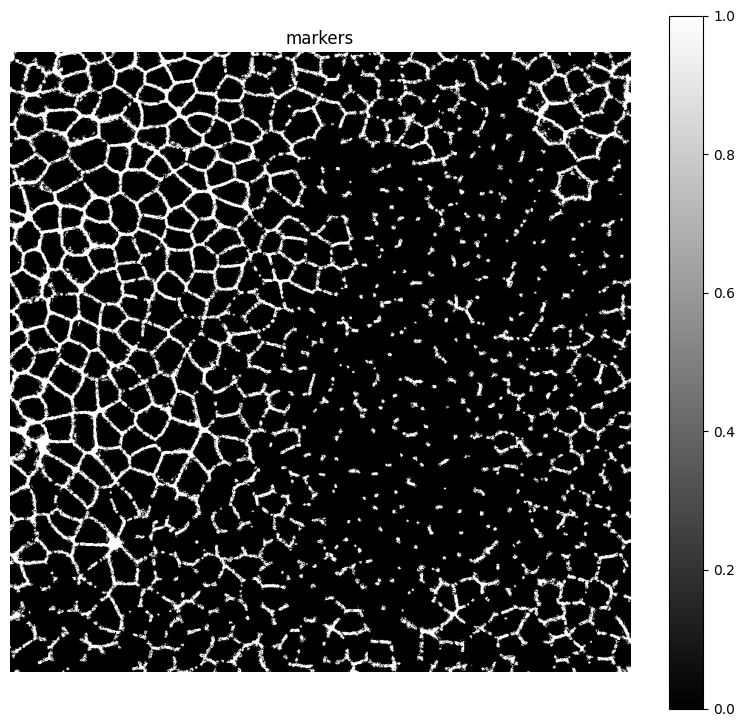

In [11]:

markers = np.zeros_like(im_g)
test=newim
markers[test < np.mean(test)+np.std(test)] = 0
markers[test >= np.mean(test)+np.std(test)] = 1
#markers=find_boundaries(markers)
#markers=rank.mean(markers, sk.disk(1))
#markers=sk.binary_opening(markers, sk.disk(2))
#markers=sk.binary_closing(markers, sk.disk(2))
#marker=sk.remove_small_objects(markers, min_size=5, connectivity=1)
#markers=sk.binary_dilation(markers, sk.disk(2))
#markers=sk.binary_closing(markers, sk.disk(1))
#marker=sk.medial_axis(markers)
fig, ax = plt.subplots(figsize=(10, 9))
f1=ax.imshow(markers, cmap=plt.cm.gray)
fig.colorbar(f1)
ax.set_title('markers')
ax.axis('off')


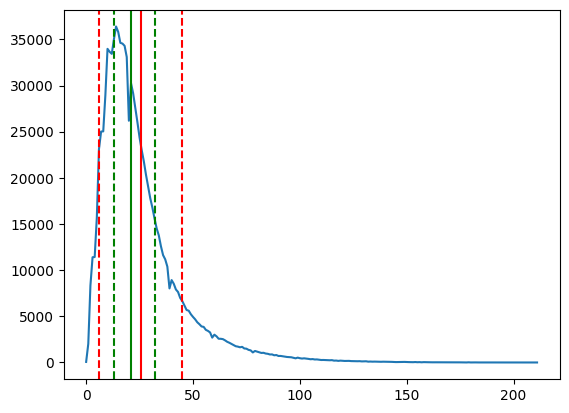

In [144]:
counts=np.unique(im_g,return_counts=True)[1]
plt.plot(counts)

plt.axvline(np.mean(im_g), c='red')
plt.axvline(np.median(im_g), c='green')
plt.axvline(np.mean(im_g)+np.std(im_g),linestyle= '--', c='red')
plt.axvline(np.mean(im_g)-np.std(im_g),linestyle= '--', c='red')
plt.axvline(np.quantile(im_g, 0.25),linestyle= '--', c='green')
plt.axvline(np.quantile(im_g, 0.75),linestyle= '--', c='green')

plt.show()


(array([9.2200e+02, 1.4572e+04, 4.6916e+04, 3.4339e+04, 2.2924e+04,
        2.2080e+04, 1.7163e+04, 2.6283e+04, 3.2233e+04, 5.1645e+04,
        3.6244e+04, 3.5035e+04, 2.4191e+04, 2.3455e+04, 3.2101e+04,
        3.0140e+04, 4.0421e+04, 2.9162e+04, 3.0505e+04, 2.1935e+04,
        2.6525e+04, 2.1596e+04, 2.2517e+04, 2.8148e+04, 2.0505e+04,
        2.2653e+04, 1.6734e+04, 1.9539e+04, 1.5375e+04, 1.9091e+04,
        1.4744e+04, 1.3656e+04, 1.5429e+04, 1.1301e+04, 1.3442e+04,
        1.0567e+04, 1.2448e+04, 9.4880e+03, 1.1009e+04, 8.1630e+03,
        7.4240e+03, 8.7450e+03, 6.6000e+03, 7.9070e+03, 5.9930e+03,
        6.9530e+03, 5.1500e+03, 6.0860e+03, 4.6430e+03, 4.3530e+03,
        5.0770e+03, 3.8280e+03, 4.4210e+03, 3.2910e+03, 3.9200e+03,
        2.8980e+03, 3.3580e+03, 2.6520e+03, 2.4980e+03, 2.9290e+03,
        2.2270e+03, 2.5370e+03, 1.8890e+03, 2.3510e+03, 1.7450e+03,
        2.0270e+03, 1.6100e+03, 1.5140e+03, 1.6980e+03, 1.2950e+03,
        1.5580e+03, 1.1860e+03, 1.3380e+03, 1.02

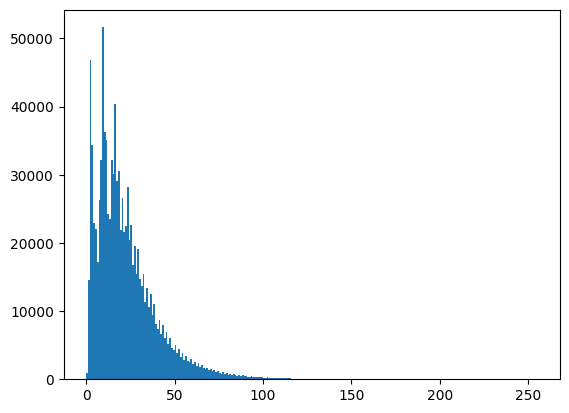

In [12]:
plt.hist(np.unique(im_g,return_counts=True)[0], weights=np.unique(im_g,return_counts=True)[1], bins=255)

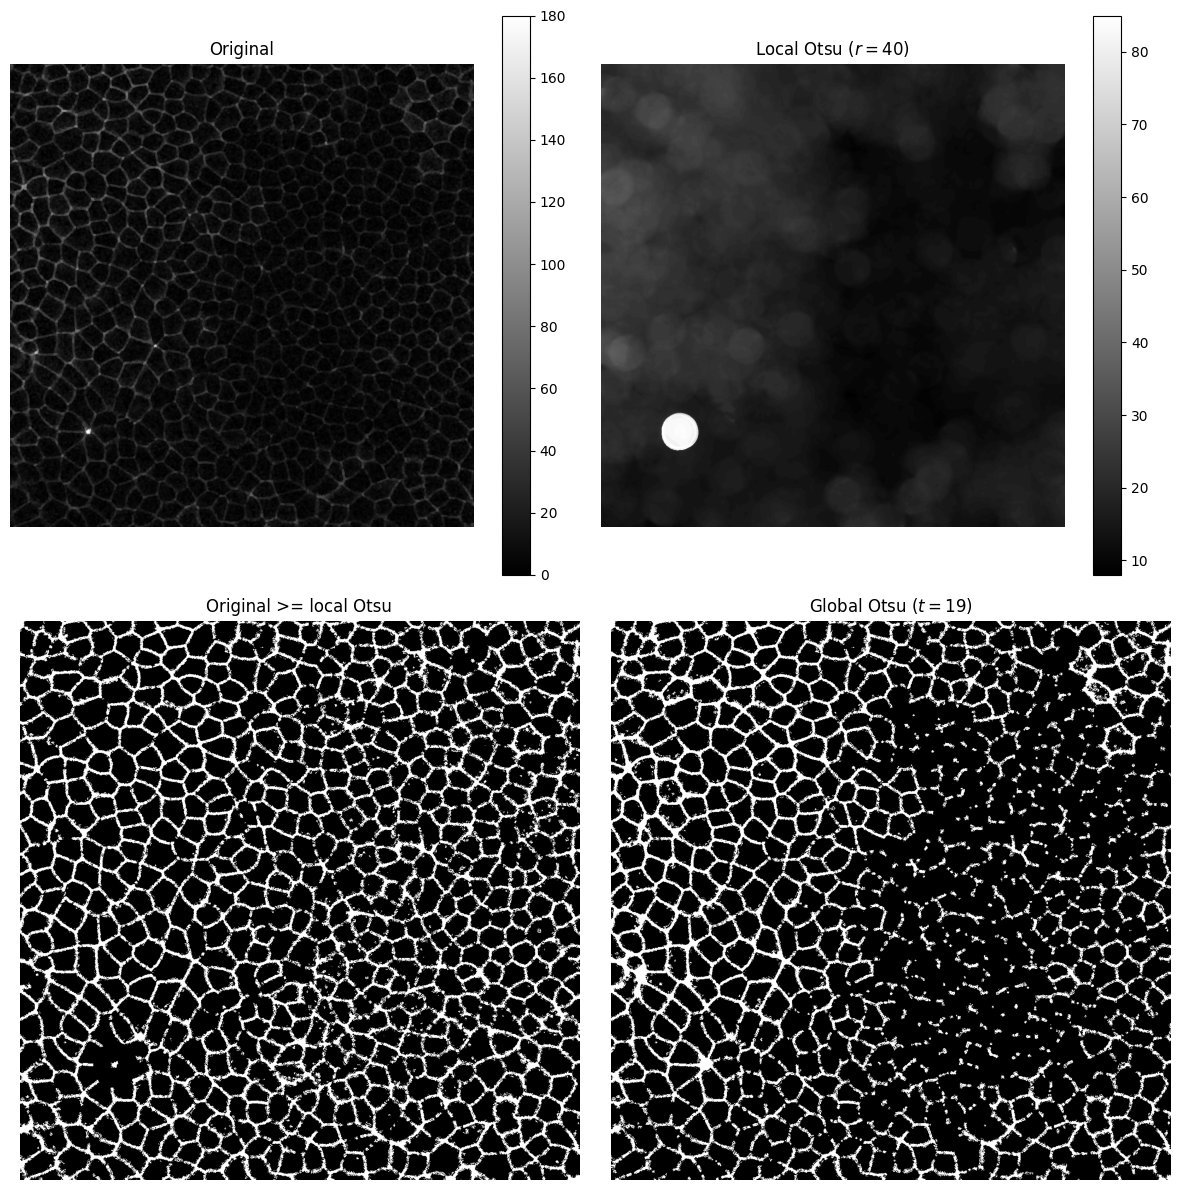

In [13]:
radius = 40
footprint = sk.disk(radius)
test=newim
# t_loc_otsu is an image
t_loc_otsu = rank.otsu(test, footprint)
loc_otsu = test >= t_loc_otsu

# t_glob_otsu is a scalar
t_glob_otsu = threshold_otsu(test)
glob_otsu = test >= t_glob_otsu

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12),
                         sharex=True, sharey=True)
ax = axes.ravel()

fig.colorbar(ax[0].imshow(test, cmap=plt.cm.gray), ax=ax[0])
ax[0].set_title('Original')

fig.colorbar(ax[1].imshow(t_loc_otsu, cmap=plt.cm.gray), ax=ax[1])
ax[1].set_title(f'Local Otsu ($r={radius}$)')

ax[2].imshow(test>= t_loc_otsu, cmap=plt.cm.gray)
ax[2].set_title('Original >= local Otsu')

ax[3].imshow(glob_otsu, cmap=plt.cm.gray)
ax[3].set_title(f'Global Otsu ($t={t_glob_otsu}$)')

for a in ax:
    a.axis('off')

plt.tight_layout()

(-0.5, 1023.5, 1023.5, -0.5)

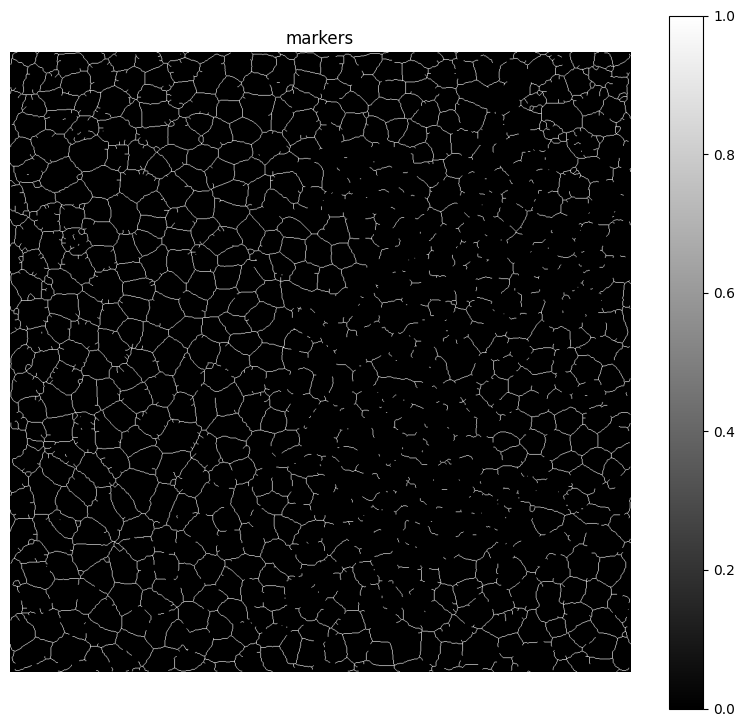

In [14]:
t_go=sk.binary_dilation(glob_otsu)
t_go=sk.binary_closing(t_go)


fig, ax = plt.subplots(figsize=(10, 9))
f1=ax.imshow(sk.skeletonize(t_go), cmap=plt.cm.gray)
fig.colorbar(f1)
ax.set_title('markers')
ax.axis('off')


In [185]:
glob_otsu

Array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

(-0.5, 1023.5, 1023.5, -0.5)

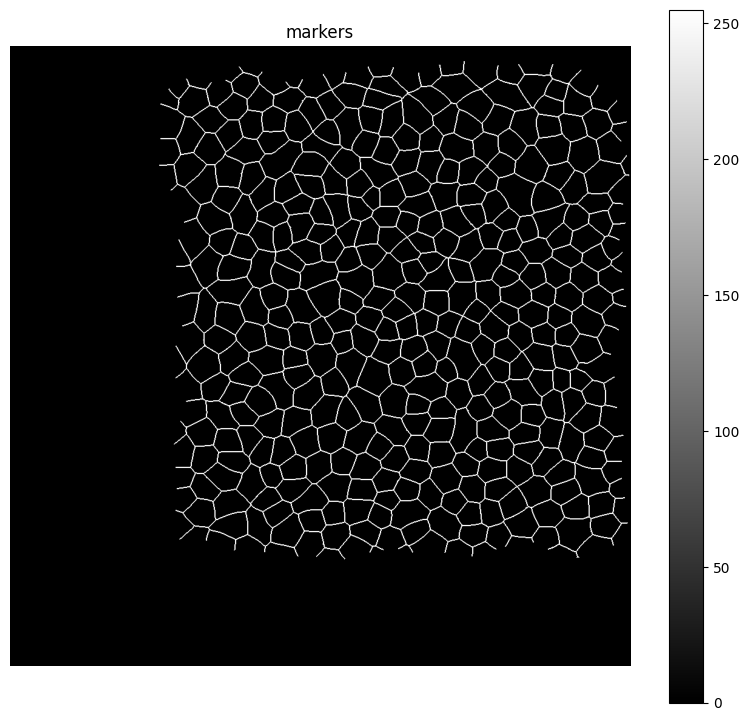

In [16]:
trace_file=glob("C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Stretched/Tracked/20240503_1_IP_GFPCAAX-CheHis_uf_8p6_SP/Frames/traces/*_trace*.tif")
trace= iio.v2.imread(trace_file[0])

fig, ax = plt.subplots(figsize=(10, 9))
f1=ax.imshow(trace, cmap=plt.cm.gray)
fig.colorbar(f1)
ax.set_title('markers')
ax.axis('off')